In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user10\Anaconda3\envs\P

In [391]:
#normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

#scale back to the true range
def true_range(df, x, response):
    X = (x * (df[response].max() - df[response].min())) + df[response].min()
    return X

#rolling windows
def train_windows(df, response, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        #扣掉response
        #記得最後一行要放response
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day][response]))
    return np.array(X_train), np.array(Y_train)

#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, equity_value, num_transaction):
    #return
    Return = equity_value_['equity_value'].iloc[-1]
    print('return:', Return)
    #vol
    Std = equity_value_['equity_value'].std()
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #odds ratio
    Odd = (R[R > 0].count() / len(num_transaction)).iloc[0]
    print('odds ratio:', Odd)
    #mdd
    
    #skew
    Skew = equity_value['equity_value'].skew()
    print('skewness:', Skew)
    #turnover

# data preprocessing

In [421]:
df = pd.read_csv('./data/3227_2.csv')
#data preprocessing
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a43_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a54_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) + (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) + (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
df['da1_dt'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt'] = df['Bid5'] - df['Bid5'].shift(1)
df['daq1_dt'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt'] = df['BidQty5'] - df['BidQty5'].shift(1)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
df = df.drop([0])
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
df = df.drop(['b43_diff_abs'], axis = 1)
df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [422]:
#no 4/13 data, drop 4/14 instead
df = df[df['TxTime'] != '2020-04-14']
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)
#find index
idx = df['TxTime'].unique()

In [186]:
#adjust the parameters in lstm
batch_size = [128, 256, 512]
validation_split = [0.1, 0.2, 0.3]
#normalize
norm_df = normalize(df2)
#train test split (10days / 4days)
test = norm_df.iloc[187412: ]
test = test.reset_index(drop = True)
train = norm_df.iloc[0:187412]
#10 days forecast next day
X_train, Y_train = train_windows(train, 'mid1', 10, 1)
X_test, Y_test = train_windows(test, 'mid1', 10, 1)

In [7]:
#adding drop out layer(pct = 0.5)
#batch size = 256
#validation split = 0.3 (not letting val loss < loss)
#early stop -> val loss patience = 10
model_1 = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="val_mean_squared_error", patience=10, verbose=1, mode="min")
history_1 = model_1.fit(X_train, Y_train, epochs=500, batch_size=batch_size[1], validation_split=validation_split[2], callbacks=[callback], shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 256)           329728    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 1)             257       
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

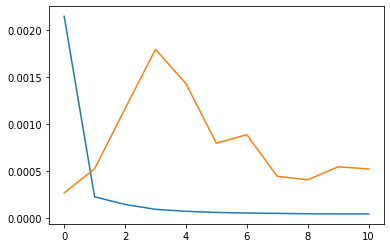

In [8]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

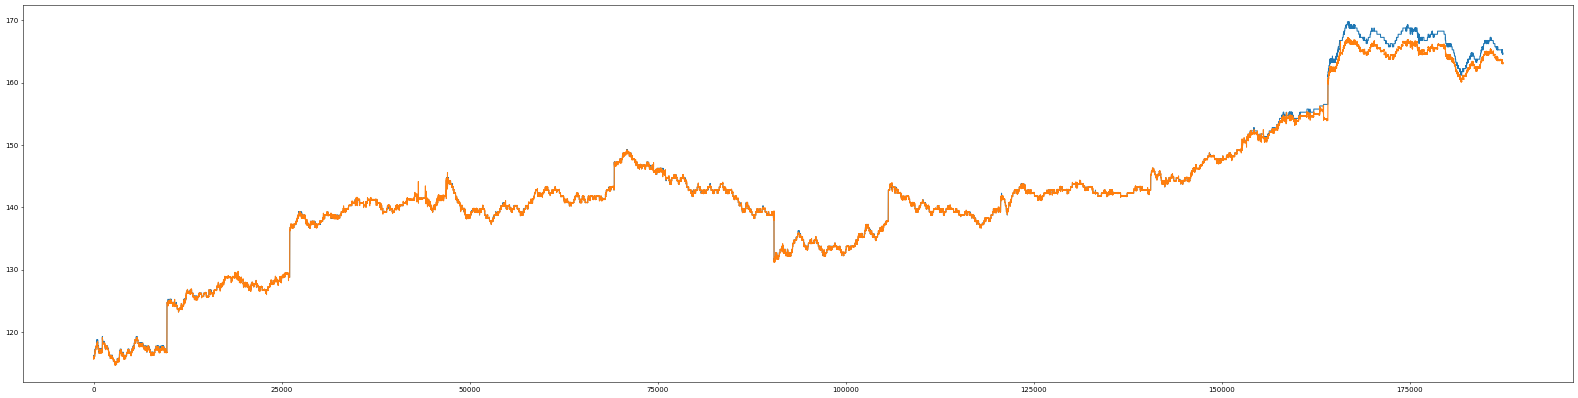

In [9]:
#train error
X_t1 = model_1.predict(X_train)
plt.figure(figsize=(40,10),dpi=50)
plt.plot(true_range(df2, Y_train, 'mid1'))
plt.plot(true_range(df2, X_t1, 'mid1'))

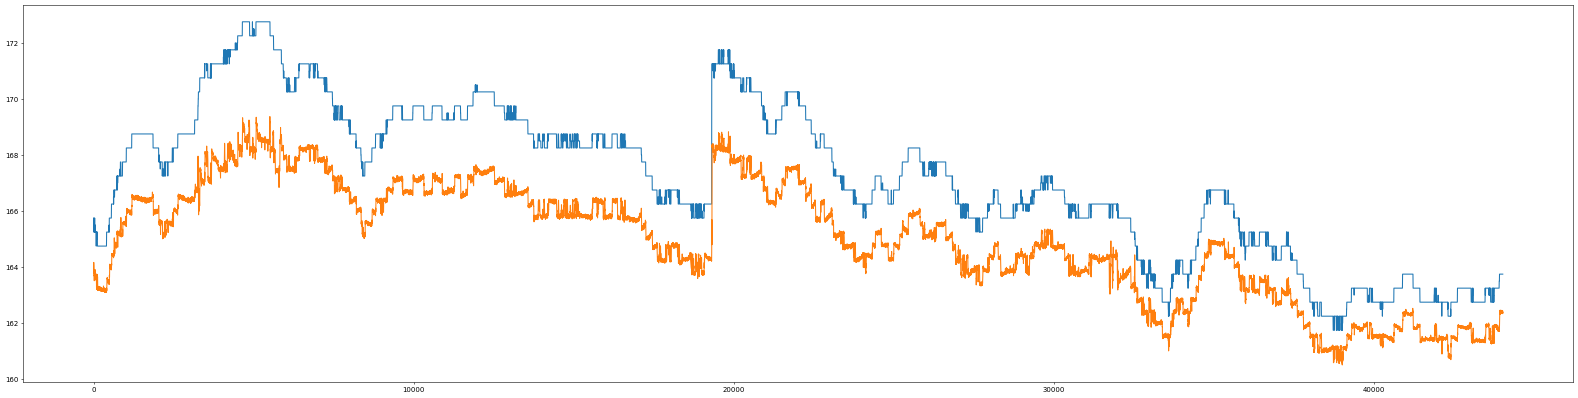

In [10]:
#test error
Xt1 = model_1.predict(X_test)
plt.figure(figsize=(40,10),dpi=50)
plt.plot(true_range(df2, Y_test, 'mid1'))
plt.plot(true_range(df2, Xt1, 'mid1'))

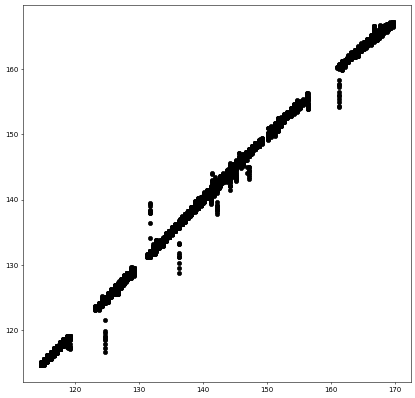

In [11]:
#train error scatter plot
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(true_range(df2, Y_train, 'mid1'), true_range(df2, X_t1, 'mid1'), color = ['black'])

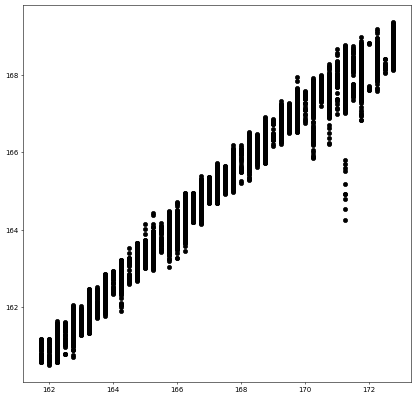

In [12]:
#test error scatter plot
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(true_range(df2, Y_test, 'mid1'), true_range(df2, Xt1, 'mid1'), color = ['black'])

In [423]:
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df_test = df.iloc[187412: ]
df_train = df.iloc[0:187412]
#1~10 pred 11, hence start from 11
df_train = df_train.iloc[11:, :]
df_test = df_test.iloc[11:, :]
#calculate pred return
df_train['pred_mid'] = true_range(df2, X_t1, 'mid1')
df_train['mid_shift'] = df_train['pred_mid'].shift(1)
df_test['pred_mid'] = true_range(df2, Xt1, 'mid1')
df_test['mid_shift'] = df_test['pred_mid'].shift(1)
#pred return train
df_train['pred_return'] = (df_train['pred_mid'] / df_train['mid_shift']) - 1
#pred return test
df_test['pred_return'] = (df_test['pred_mid'] / df_test['mid_shift']) - 1

In [424]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_train = df_train.drop([0])
df_train = df_train.reset_index(drop = True)
df_test = df_test.drop([0])
df_test = df_test.reset_index(drop = True)

In [372]:
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq1_dt,dbq2_dt,dbq3_dt,dbq4_dt,dbq5_dt,mid1,equity_value,pred_mid,mid_shift,pred_return
0,0.0,0,30,165.0,166.0,58,13,164.5,166.5,27,...,0.0,0.0,0.0,1.0,0.0,165.50,0.0,164.103439,163.828247,0.001680
1,0.0,0,30,165.0,165.5,1,13,164.5,166.0,58,...,0.0,0.0,0.0,0.0,0.0,165.25,0.0,164.168091,164.103439,0.000394
2,0.0,0,30,165.0,165.5,2,13,164.5,166.0,58,...,0.0,0.0,0.0,0.0,0.0,165.25,0.0,164.137451,164.168091,-0.000187
3,0.0,0,30,165.0,165.5,2,9,164.5,166.0,58,...,0.0,-4.0,0.0,0.0,0.0,165.25,0.0,164.073883,164.137451,-0.000387
4,165.5,1,30,165.0,165.5,1,9,164.5,166.0,58,...,0.0,0.0,0.0,0.0,0.0,165.25,0.0,164.062576,164.073883,-0.000069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44013,0.0,0,29,163.5,164.0,72,68,163.0,164.5,71,...,0.0,1.0,0.0,0.0,0.0,163.75,0.0,162.374954,162.374725,0.000001
44014,0.0,0,29,163.5,164.0,72,69,163.0,164.5,71,...,0.0,1.0,0.0,0.0,0.0,163.75,0.0,162.340637,162.374954,-0.000211
44015,0.0,0,29,163.5,164.0,72,69,163.0,164.5,71,...,0.0,0.0,0.0,0.0,0.0,163.75,0.0,162.352936,162.340637,0.000076
44016,0.0,0,29,163.5,164.0,72,70,163.0,164.5,71,...,0.0,1.0,0.0,0.0,0.0,163.75,0.0,162.410889,162.352936,0.000357


# mid1_train

In [565]:
#setting parameters
import itertools 
long_side, short_side = [0.003, 0.0025, 0.002, 0.0015, 0.001], [-0.003, -0.0025, -0.002, -0.0015, -0.001]
paras = list(itertools.product(long_side, short_side))
paras

[(0.003, -0.003),
 (0.003, -0.0025),
 (0.003, -0.002),
 (0.003, -0.0015),
 (0.003, -0.001),
 (0.0025, -0.003),
 (0.0025, -0.0025),
 (0.0025, -0.002),
 (0.0025, -0.0015),
 (0.0025, -0.001),
 (0.002, -0.003),
 (0.002, -0.0025),
 (0.002, -0.002),
 (0.002, -0.0015),
 (0.002, -0.001),
 (0.0015, -0.003),
 (0.0015, -0.0025),
 (0.0015, -0.002),
 (0.0015, -0.0015),
 (0.0015, -0.001),
 (0.001, -0.003),
 (0.001, -0.0025),
 (0.001, -0.002),
 (0.001, -0.0015),
 (0.001, -0.001)]

In [566]:
#adding hard stop (+ 0.01, -0.01)
#main strategy (train set)
#record transaction
transaction_history = {}
#record equity values
equity_value_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    equity_value1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    side = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    side = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    transaction_history = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history)
                else:
                    side = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if side == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history[paras[l]][-1]['Price'] - 1) - 0.0015
                    num_transaction.append(i)
                    transaction_history = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (side == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history[paras[l]][-1]['Price'] - 1) * (-1)
                    num_transaction.append(i)
                    transaction_history = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history)
                #收盤如果漲停，空單結不掉
                #elif (side == -1) and (df['Ask1'].iloc[i] == 0):
                    #df['equity_value'].iloc[i] = (df['Ask2'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if (side == 1 and df['side'].iloc[i] == 1) or (side == 1 and df['side'].iloc[i] == 0):
                    side = 1
                    df['equity_value'].iloc[i] = 0 
                elif (side == 1 and (df['mid1'].iloc[i-1] / transaction_history[paras[l]][-1]['Price'] - 1) < -0.01) or (side == 1 and (df['mid1'].iloc[i-1] / transaction_history[paras[l]][-1]['Price'] - 1) > 0.01):
                    side = 0
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history[paras[l]][-1]['Price'] - 1) - 0.0015
                    num_transaction.append(i)
                    transaction_history = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history)
                elif side == 0 and df['side'].iloc[i] == 0:
                    side = 0
                    df['equity_value'].iloc[i] = 0
                #ask1 may be 0, which means 漲停 (買不到)
                elif (side == 0) and (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    side = 1
                    df['equity_value'].iloc[i] = 0
                    #stock_price = df['Ask1'].iloc[i]
                    transaction_history = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history)
                elif (side == 0) and (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif side == 0 and df['side'].iloc[i] == -1:
                    side = -1
                    df['equity_value'].iloc[i] = - 0.0015
                    #stock_price = df['Bid1'].iloc[i]
                    transaction_history = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history)
                elif (side == -1 and df['side'].iloc[i] == 0) or (side == -1 and df['side'].iloc[i] == -1):
                    side = -1
                    df['equity_value'].iloc[i] = 0
                #ask1 may be 0, which means 漲停 (買不到)
                elif ((side == -1) and (df['Ask1'].iloc[i] != 0) and (df['mid1'].iloc[i-1] / transaction_history[paras[l]][-1]['Price'] - 1) * (-1) < -0.01) or ((side == -1) and (df['Ask1'].iloc[i] != 0) and (df['mid1'].iloc[i-1] / transaction_history[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                    side = 0
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history[paras[l]][-1]['Price'] - 1) * (-1)
                    num_transaction.append(i)
                    transaction_history = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history)
                elif (side == -1) and (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = -1
                    df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
    #plt.subplot(5, 5, l+1)
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    #plt.plot(equity_value_1['equity_value'].iloc[:, l])
    #print(transaction_history)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

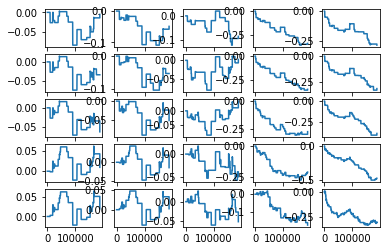

In [567]:
#cumulative return
for i in range(len(paras)):
    plt.subplot(5, 5, i+1)
    plt.plot(equity_value_1['equity_value'].iloc[:, i])

In [568]:
equity_value_1.columns = paras
equity_value_1.iloc[-1].idxmax()

(0.002, -0.002)

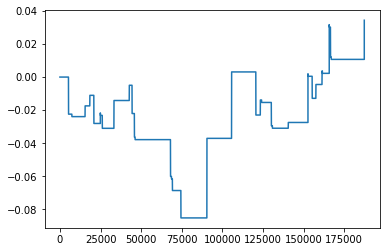

In [600]:
plt.plot(equity_value_1[(0.002, -0.002)])

In [591]:
equity_value_1.iloc[-1].max()

0.034361429459043254

In [593]:
equity_value_1.iloc[-1][equity_value_1.iloc[-1] > 0]

(0.0025, -0.002)    0.002323
(0.002, -0.002)     0.034361
(0.0015, -0.003)    0.009702
(0.001, -0.003)     0.019263
(0.001, -0.0025)    0.002458
Name: 187399, dtype: float64

In [584]:
equity_value_1.iloc[-1] > 0

(0.003, -0.003)      False
(0.003, -0.0025)     False
(0.003, -0.002)      False
(0.003, -0.0015)     False
(0.003, -0.001)      False
(0.0025, -0.003)     False
(0.0025, -0.0025)    False
(0.0025, -0.002)      True
(0.0025, -0.0015)    False
(0.0025, -0.001)     False
(0.002, -0.003)      False
(0.002, -0.0025)     False
(0.002, -0.002)       True
(0.002, -0.0015)     False
(0.002, -0.001)      False
(0.0015, -0.003)      True
(0.0015, -0.0025)    False
(0.0015, -0.002)     False
(0.0015, -0.0015)    False
(0.0015, -0.001)     False
(0.001, -0.003)       True
(0.001, -0.0025)      True
(0.001, -0.002)      False
(0.001, -0.0015)     False
(0.001, -0.001)      False
Name: 187399, dtype: bool

# mid1_test 

In [585]:
#test set
paras = [(0.0025, -0.002), (0.002, -0.002), (0.0015, -0.003), (0.001, -0.003), (0.001, -0.0025)]

In [586]:
#adding hard stop (+ 0.01, -0.01)
#main strategy (train set)
#record transaction
transaction_history = {}
#record equity values
equity_value_2 = pd.DataFrame()
for l in range(len(paras)):
    df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
    for j in range(len(df_test)):
        if df_test['pred_return'].iloc[j] > paras[l][0]:
            df_test['side'].iloc[j] = 1
        elif df_test['pred_return'].iloc[j] < paras[l][1]:
            df_test['side'].iloc[j] = -1
    date_idx = df_test['TxTime'].unique()
    equity_value2 = pd.DataFrame()
    for k in date_idx:
        df = df_test[df_test.TxTime == k]
        side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    side = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    side = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    transaction_history = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history)
                else:
                    side = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if side == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history[paras[l]][-1]['Price'] - 1) - 0.0015
                    num_transaction.append(i)
                    transaction_history = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (side == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history[paras[l]][-1]['Price'] - 1) * (-1)
                    num_transaction.append(i)
                    transaction_history = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history)
                #收盤如果漲停，空單結不掉
                #elif (side == -1) and (df['Ask1'].iloc[i] == 0):
                    #df['equity_value'].iloc[i] = (df['Ask2'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if (side == 1 and df['side'].iloc[i] == 1) or (side == 1 and df['side'].iloc[i] == 0):
                    side = 1
                    df['equity_value'].iloc[i] = 0 
                elif (side == 1 and (df['mid1'].iloc[i-1] / transaction_history[paras[l]][-1]['Price'] - 1) < -0.01) or (side == 1 and (df['mid1'].iloc[i-1] / transaction_history[paras[l]][-1]['Price'] - 1) > 0.01):
                    side = 0
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history[paras[l]][-1]['Price'] - 1) - 0.0015
                    num_transaction.append(i)
                    transaction_history = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history)
                elif side == 0 and df['side'].iloc[i] == 0:
                    side = 0
                    df['equity_value'].iloc[i] = 0
                #ask1 may be 0, which means 漲停 (買不到)
                elif (side == 0) and (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    side = 1
                    df['equity_value'].iloc[i] = 0
                    #stock_price = df['Ask1'].iloc[i]
                    transaction_history = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history)
                elif (side == 0) and (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif side == 0 and df['side'].iloc[i] == -1:
                    side = -1
                    df['equity_value'].iloc[i] = - 0.0015
                    #stock_price = df['Bid1'].iloc[i]
                    transaction_history = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history)
                elif (side == -1 and df['side'].iloc[i] == 0) or (side == -1 and df['side'].iloc[i] == -1):
                    side = -1
                    df['equity_value'].iloc[i] = 0
                #ask1 may be 0, which means 漲停 (買不到)
                elif ((side == -1) and (df['Ask1'].iloc[i] != 0) and (df['mid1'].iloc[i-1] / transaction_history[paras[l]][-1]['Price'] - 1) * (-1) < -0.01) or ((side == -1) and (df['Ask1'].iloc[i] != 0) and (df['mid1'].iloc[i-1] / transaction_history[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                    side = 0
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history[paras[l]][-1]['Price'] - 1) * (-1)
                    num_transaction.append(i)
                    transaction_history = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history)
                elif (side == -1) and (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = -1
                    df['equity_value'].iloc[i] = 0
        equity_value2 = pd.concat([equity_value2, df[['equity_value']]])
    #plt.subplot(5, 5, l+1)
    equity_value_2 = pd.concat([equity_value_2, np.cumsum(equity_value2)], axis = 1)
    #plt.plot(equity_value_1['equity_value'].iloc[:, l])
    #print(transaction_history)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

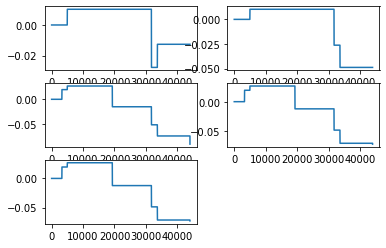

In [588]:
#cumulative return (test)
for i in range(len(paras)):
    plt.subplot(3, 2, i+1)
    plt.plot(equity_value_2['equity_value'].iloc[:, i])

In [589]:
equity_value_2.columns = paras
equity_value_2.iloc[-1].idxmax()

(0.0025, -0.002)

In [590]:
equity_value_2.iloc[-1]

(0.0025, -0.002)   -0.012615
(0.002, -0.002)    -0.048805
(0.0015, -0.003)   -0.090710
(0.001, -0.003)    -0.072869
(0.001, -0.0025)   -0.072869
Name: 44017, dtype: float64

In [596]:
np.sum(df_test['pred_return'] > 0.001)

313

In [597]:
np.sum(df_test['pred_return'] < -0.0025)

11

In [599]:
transaction_history[(0.001, -0.0025)]

[{'Date': '2020-04-08',
  'tick': 0,
  'Action': 1,
  'Price': 166.0,
  'Equity_value': 0},
 {'Date': '2020-04-08',
  'tick': 3260,
  'Action': -1,
  'Price': 169.5,
  'Equity_value': 0.01958433734939763},
 {'Date': '2020-04-08',
  'tick': 3266,
  'Action': 1,
  'Price': 170.5,
  'Equity_value': 0},
 {'Date': '2020-04-08',
  'tick': 4968,
  'Action': -1,
  'Price': 172.0,
  'Equity_value': 0.007297653958944274},
 {'Date': '2020-04-08',
  'tick': 4970,
  'Action': 1,
  'Price': 172.5,
  'Equity_value': 0},
 {'Date': '2020-04-08',
  'tick': 19302,
  'Action': -1,
  'Price': 166.0,
  'Equity_value': -0.039181159420289824},
 {'Date': '2020-04-09',
  'tick': 2,
  'Action': 1,
  'Price': 171.5,
  'Equity_value': 0},
 {'Date': '2020-04-09',
  'tick': 12436,
  'Action': -1,
  'Price': 165.5,
  'Equity_value': -0.03648542274052474},
 {'Date': '2020-04-09',
  'tick': 12437,
  'Action': 1,
  'Price': 166.0,
  'Equity_value': 0},
 {'Date': '2020-04-09',
  'tick': 14329,
  'Action': -1,
  'Price': 

In [606]:
equity_value2[equity_value2['equity_value'] != 0]

,equity_value
3260,0.019584
4968,0.007298
19302,-0.039181
31739,-0.036485
33632,-0.022584
44017,-0.001500


In [607]:
equity_value2.index[equity_value2['equity_value'] != 0].tolist()

[3260, 4968, 19302, 31739, 33632, 44017]

In [608]:
equity_value2.iloc[3260]

equity_value    0.019584
Name: 3260, dtype: float64